# Extract & Re-Inject Pulse

## Use burstfit to extract a pulse, then re-inject into the same file

In [1]:
import tempfile
from typing import Union
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject
from your import Your

In [2]:
# !pip install  git+https://github.com/thepetabyteproject/burstfit
# I had to make some changes to burstfit to get the plotting to work
from burstfit.data import BurstData
from burstfit.fit import BurstFit
from burstfit.io import BurstIO
from burstfit.model import Model, SgramModel
from burstfit.utils.functions import gauss_norm, gauss_norm2, pulse_fn_vec, sgram_fn_vec
from burstfit.utils.plotter import plot_me

In [3]:
def show_dynamic(
    dynamic_spectra: np.ndarray,
    title: Union[str, None] = None,
    save: Union[bool, None] = False,
) -> None:
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra: the dynamic spectra to plot

        title: Title of plot

        save: Save the plot as `title` + `.png`

    Returns:
        None
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(14, 7))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std, aspect="auto")
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title.replace(" ", "_") + ".png", dpi=75, bbox_inches="tight")

## Extract the pulse using burstfit

This is copied from the burstfit documentation,
https://github.com/thepetabyteproject/burstfit/blob/main/examples/BurstFit_custom_function.ipynb

In [4]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/FRB180417.fil"
url = "https://zenodo.org/record/3905426/files/FRB180417.fil"
urlretrieve(
    url,
    download_path,
)
fil_file = download_path

### Make a simple channel mask

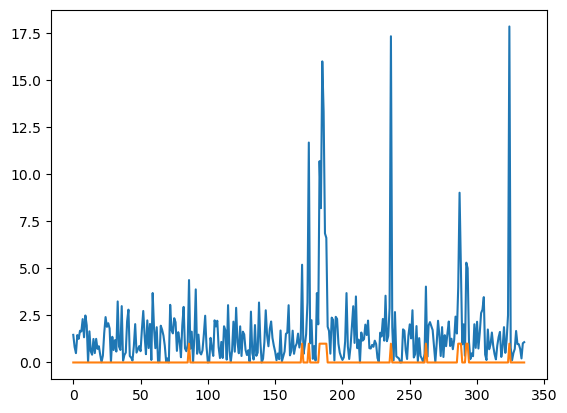

In [5]:
yr_obj = Your(fil_file)
dynamic_spectra = yr_obj.get_data(0, yr_obj.your_header.nspectra)

stds = dynamic_spectra.std(axis=0)
stds -= np.median(stds)
np.abs(stds, out=stds)
stds /= median_abs_deviation(stds, scale="normal")
plt.plot(stds)

chan_mask = stds > 4
plt.plot(chan_mask)

In [6]:
DM = 475.28400
bd = BurstData(
    fp=fil_file,
    dm=DM,
    tcand=2.0288800,
    width=2,
    snr=16.8128,
)

In [7]:
# We need the indices of the bad channels
bad_chans = np.arange(0, yr_obj.your_header.nchans)[chan_mask].tolist()

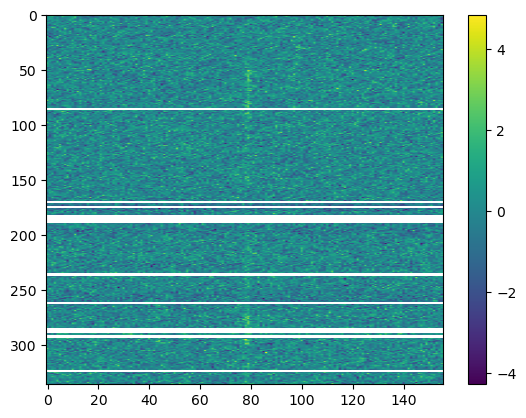

In [8]:
bd.prepare_data(mask_chans=bad_chans)
plot_me(bd.sgram)

In [9]:
pnames = ["S", "mu_t", "sigma_t", "tau"]
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model
snames = ["mu_f", "sigma_f"]
spectraModel = Model(gauss_norm, param_names=snames)

sgramModel = SgramModel(
    pulseModel, spectraModel, sgram_fn_vec, mask=chan_mask, clip_fac=bd.clip_fac
)

snames = ["mu_f1", "sigma_f1", "mu_f2", "sigma_f2", "amp"]
spectraModel2 = Model(gauss_norm2, param_names=snames)
spectra_bounds = ([0, 0, 200, 0, 0], [100, 50, 300, 50, 1])
sgramModel2 = SgramModel(
    pulseModel, spectraModel2, sgram_fn_vec, mask=bd.mask, clip_fac=bd.clip_fac
)

In [10]:
bf = BurstFit(
    sgram_model=sgramModel2,
    sgram=bd.sgram,
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask=bd.mask,
)

In [11]:
bf.validate()
bf.precalc()

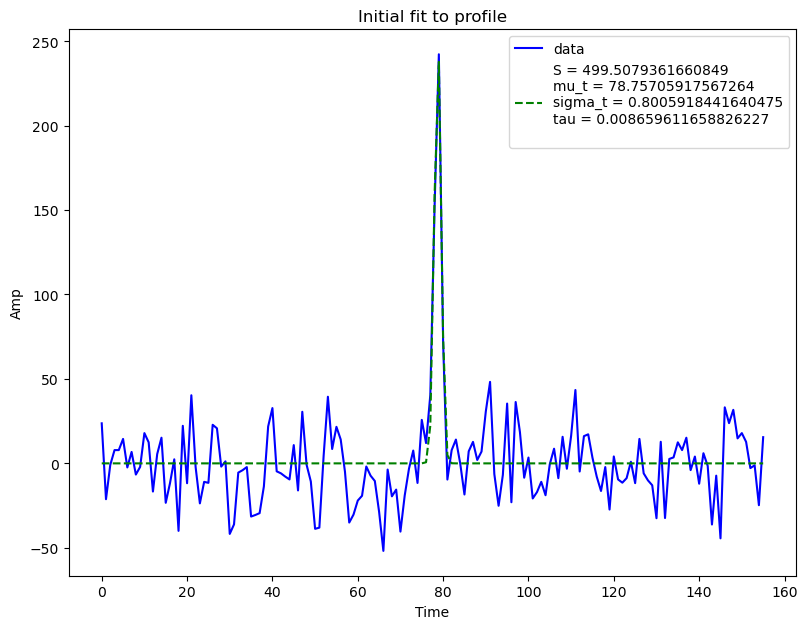

In [12]:
plot = True
bf.initial_profilefit(plot)

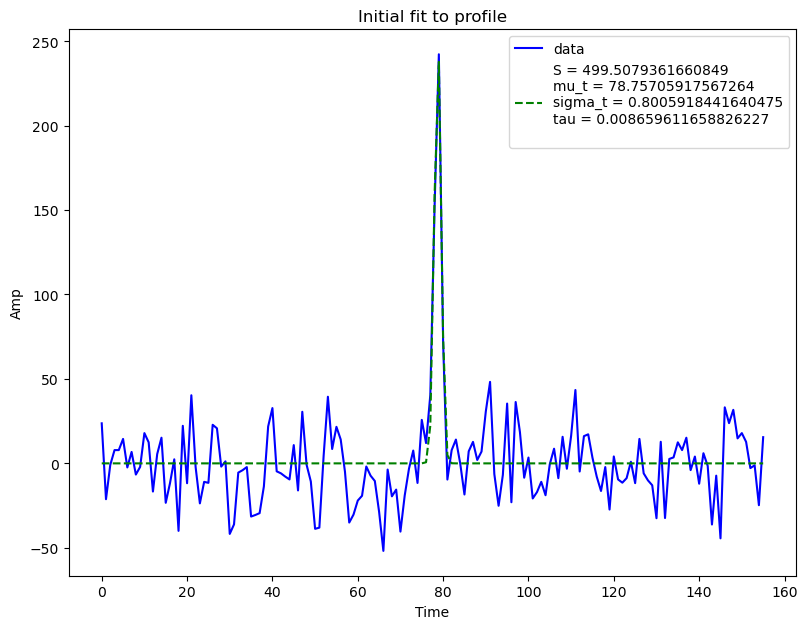

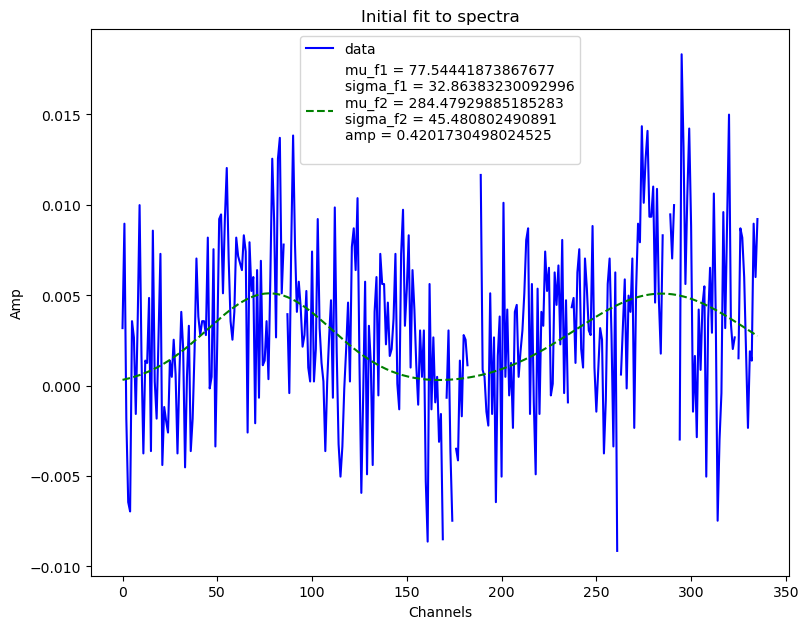

/home/joseph/python/miniconda3/envs/kpe/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


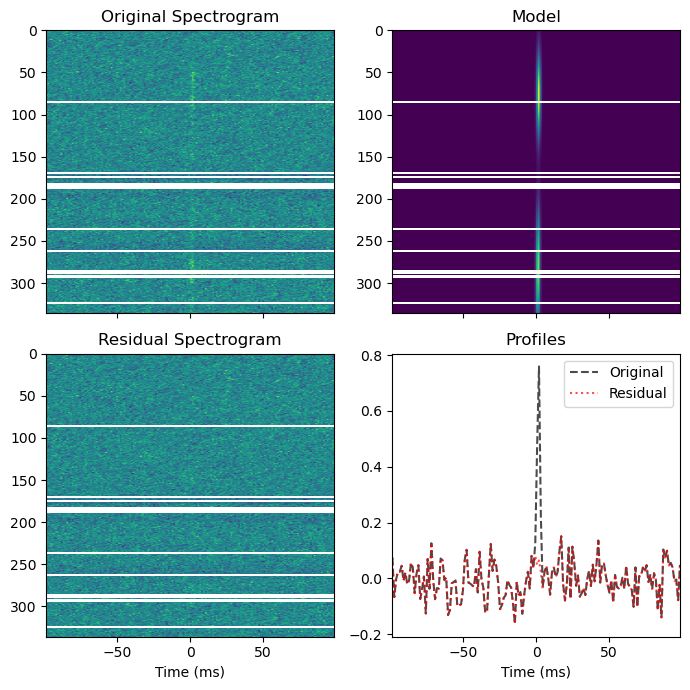

In [13]:
bf.fitall(plot=True, spectra_bounds=spectra_bounds, profile_bounds=[])

## Create the pulse

Use `WILL` with above model as the probability distribution function.

In [14]:
pulse_obj = create.TwoDimensionalPulse(
    bf.model.data.T, yr_obj.chan_freqs, tsamp=yr_obj.your_header.tsamp, dm=DM
)
# WILL has time on the vertical axis, burstfit on the horizontal, so transpose.
pulse = pulse_obj.sample_pulse(int(bf.model.data.sum()))

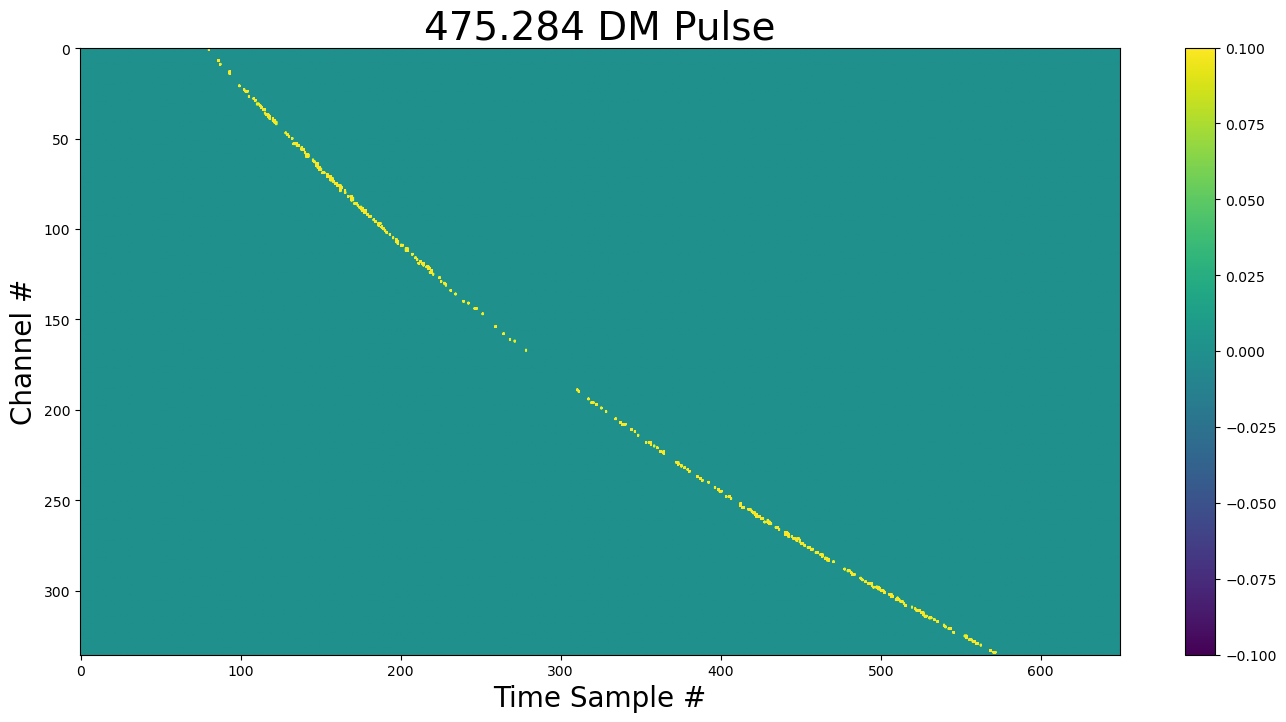

In [15]:
show_dynamic(pulse, title=f"{DM} DM Pulse")

## Inject the pulse

Original Dynamic Spectra

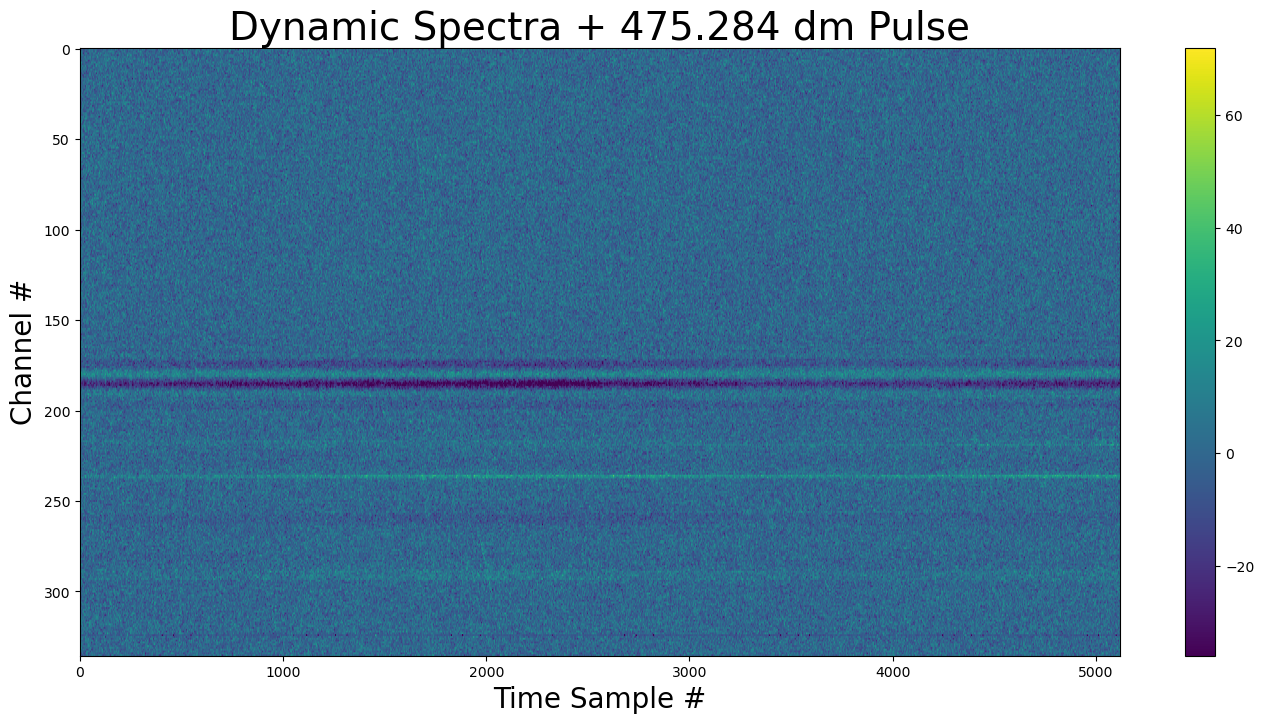

In [16]:
show_dynamic(dynamic_spectra, title=f"Dynamic Spectra + {DM} dm Pulse")

The pulse is faintly visible before sample 2000.

In [17]:
dynamic_spectra_w_pulse = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=3000,
    gulp=yr_obj.your_header.nspectra,
)

Output()

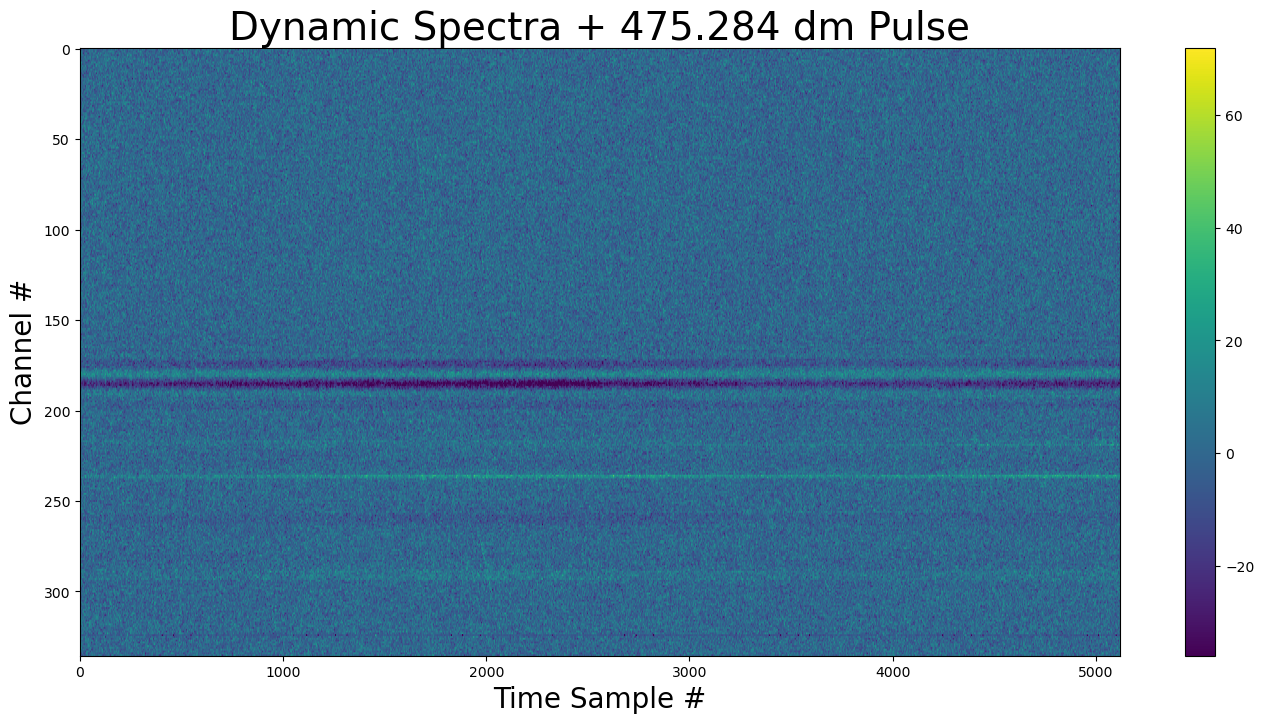

In [18]:
show_dynamic(dynamic_spectra_w_pulse, title=f"Dynamic Spectra + {DM} dm Pulse")

## It is difficult to see the new pulse, lets make it 100x brighter.

In [19]:
pulse = pulse_obj.sample_pulse(int(100 * bf.model.data.sum()))
dynamic_spectra_w_pulse = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=3000,
    gulp=yr_obj.your_header.nspectra,
)

Output()

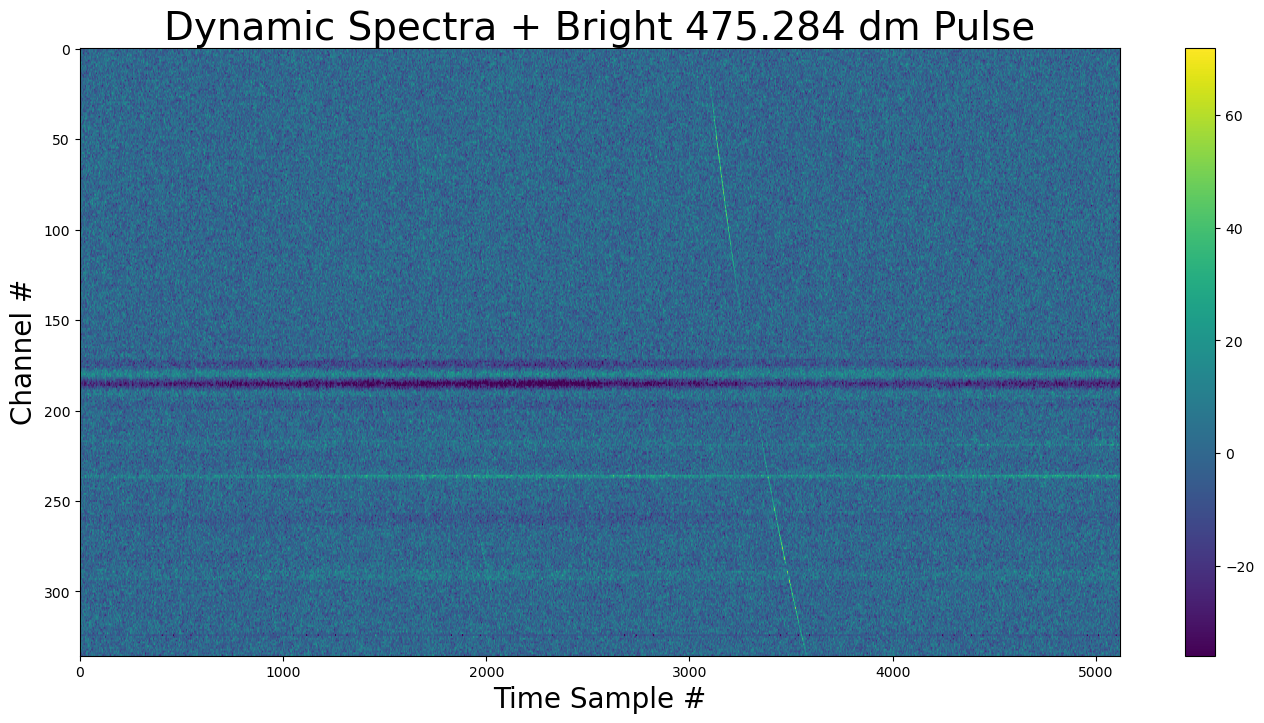

In [20]:
show_dynamic(dynamic_spectra_w_pulse, title=f"Dynamic Spectra + Bright {DM} dm Pulse")

Now the re-injected pulse is visible between time samples 3000-3500.